In [4]:
!pip install scikit-fuzzy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import skfuzzy as fuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.6 MB/s eta 0:00:00


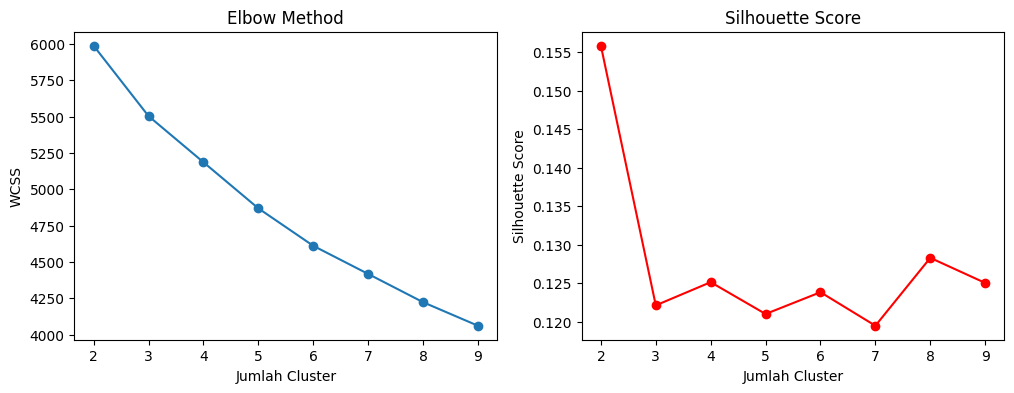

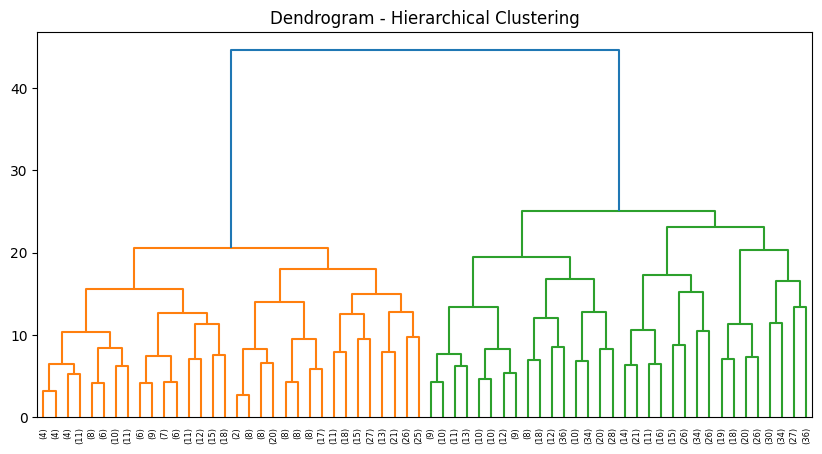

DBSCAN: eps=0.3, min_samples=5, clusters=0
DBSCAN: eps=0.3, min_samples=10, clusters=0
DBSCAN: eps=0.3, min_samples=15, clusters=0
DBSCAN: eps=0.5, min_samples=5, clusters=0
DBSCAN: eps=0.5, min_samples=10, clusters=0
DBSCAN: eps=0.5, min_samples=15, clusters=0
DBSCAN: eps=0.7, min_samples=5, clusters=0
DBSCAN: eps=0.7, min_samples=10, clusters=0
DBSCAN: eps=0.7, min_samples=15, clusters=0
Jumlah Outlier: 1000


In [12]:
# Load Dataset
df = pd.read_csv("/content/dataset_kesehatan.csv")

# Preprocessing
if 'Tekanan Darah (mmHg)' in df.columns:
    df[['Systolic', 'Diastolic']] = df['Tekanan Darah (mmHg)'].str.split('/', expand=True).astype(int)
    df.drop(columns=['Tekanan Darah (mmHg)'], inplace=True)

if 'ID Pasien' in df.columns:
    df.drop(columns=['ID Pasien'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))

# 1. K-Means Clustering + Elbow & Silhouette
wcss = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.show()

# Pilih k optimal (misalnya k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# Visualisasi BMI vs Kolesterol jika tersedia
if {'BMI', 'Kolesterol (mg/dL)'}.issubset(df.columns):
    sns.scatterplot(data=df, x='BMI', y='Kolesterol (mg/dL)', hue='Cluster_KMeans', palette='viridis')
    plt.title('K-Means Clustering (BMI vs Kolesterol)')
    plt.show()

# 2. Fuzzy C-Means
n_clusters = 4
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_scaled.T, n_clusters, 2, error=0.005, maxiter=1000)
df['Cluster_FCM'] = np.argmax(u, axis=0)

# Visualisasi FCM jika kolom tersedia
if {'BMI', 'Kolesterol (mg/dL)'}.issubset(df.columns):
    sns.scatterplot(data=df, x='BMI', y='Kolesterol (mg/dL)', hue='Cluster_FCM', palette='coolwarm')
    plt.title('Fuzzy C-Means Clustering')
    plt.show()

# 3. Hierarchical Clustering + Dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=df.index, truncate_mode='level', p=5)
plt.title('Dendrogram - Hierarchical Clustering')
plt.show()

# 4. DBSCAN Clustering
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"DBSCAN: eps={eps}, min_samples={min_samples}, clusters={n_clusters}")

# Gunakan parameter terbaik (misal eps=0.5, min_samples=10)
dbscan = DBSCAN(eps=0.5, min_samples=10)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Identifikasi Outlier (-1 adalah outlier)
outliers = df[df['Cluster_DBSCAN'] == -1]
print(f"Jumlah Outlier: {len(outliers)}")


In [19]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules


In [20]:
# --- Load Dataset ---
file_path = "/content/dataset_transaksi.csv"  # Ganti dengan path dataset yang benar
df = pd.read_csv(file_path)

# --- Preprocessing Data ---
# Mengubah kolom Items menjadi daftar produk
df['Items'] = df['Items'].apply(lambda x: x.split(','))

# Membuat daftar unik produk
all_items = sorted(set(item for sublist in df['Items'] for item in sublist))

# Konversi ke format transaksi untuk Apriori
encoded_data = pd.DataFrame(0, index=range(len(df)), columns=all_items)

for i, items in enumerate(df['Items']):
    encoded_data.loc[i, items] = 1

# --- Menjalankan Apriori ---
min_support = 0.1  # Minimum support threshold
frequent_itemsets = apriori(encoded_data, min_support=min_support, use_colnames=True)

# --- Mencari Aturan Asosiasi ---
min_confidence = 0.3  # Minimum confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Menambahkan interpretasi aturan
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])  # Urutkan aturan terbaik

# --- Menampilkan Aturan yang Signifikan ---
print("\n=== Aturan Asosiasi yang Paling Signifikan ===")
for i, row in rules.iterrows():
    antecedent = ", ".join(row['antecedents'])
    consequent = ", ".join(row['consequents'])
    print(f"Jika pelanggan membeli ({antecedent}) → kemungkinan besar juga membeli ({consequent})")
    print(f"  Support: {row['support']:.2f}, Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}\n")

# --- Rekomendasi Bisnis ---
print("\n=== Rekomendasi Strategi Supermarket ===")
print("- Produk dengan lift tinggi sebaiknya ditempatkan berdekatan karena sering dibeli bersama.")
print("- Gunakan diskon bundling untuk meningkatkan penjualan produk yang memiliki confidence tinggi.")
print("- Perhatikan produk dengan support tinggi sebagai barang yang paling diminati pelanggan.")



=== Aturan Asosiasi yang Paling Signifikan ===
Jika pelanggan membeli (Telur) → kemungkinan besar juga membeli (Buah)
  Support: 0.10, Confidence: 0.36, Lift: 1.11

Jika pelanggan membeli (Buah) → kemungkinan besar juga membeli (Telur)
  Support: 0.10, Confidence: 0.32, Lift: 1.11

Jika pelanggan membeli (Kopi) → kemungkinan besar juga membeli (Teh)
  Support: 0.11, Confidence: 0.34, Lift: 1.09

Jika pelanggan membeli (Teh) → kemungkinan besar juga membeli (Kopi)
  Support: 0.11, Confidence: 0.34, Lift: 1.09

Jika pelanggan membeli (Keju) → kemungkinan besar juga membeli (Teh)
  Support: 0.11, Confidence: 0.34, Lift: 1.08

Jika pelanggan membeli (Teh) → kemungkinan besar juga membeli (Keju)
  Support: 0.11, Confidence: 0.34, Lift: 1.08

Jika pelanggan membeli (Sayur) → kemungkinan besar juga membeli (Kopi)
  Support: 0.10, Confidence: 0.33, Lift: 1.08

Jika pelanggan membeli (Kopi) → kemungkinan besar juga membeli (Sayur)
  Support: 0.10, Confidence: 0.33, Lift: 1.08

Jika pelanggan m

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
